In [4]:
import os
import glob
import tqdm
import torch
import numpy as np
import omegaconf
from mllib.src.train import main

import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt

import torch.cuda
from mllib.src.evaluate import evaluate
from mllib.src.utils import prepare_device, load_yaml
from mllib.src.distrib import get_dev_wav_clarity

In [5]:
# config = "./result/demucs/20230201-104202/config.yaml"
# config = "./result/wav-unet/20230201-104328/config.yaml"
# config = "./result/dcunet/20230201-104116/config.yaml"

# config = "/home/daniel0413/workplace/project/SpeechEnhancement/SpeechEnhancementHL/result/dcunet/20230128-234556/config.yaml"

# config = "./mllib/result/mel-rnn/20230202-145405/config.yaml"
# config = './mllib/result/mel-rnn/20230203-121042/config.yaml'

# config = "./mllib/result/dnn/20230202-142249/config.yaml"
# config = "./mllib/result/dnn/20230202-163959/config.yaml"
# config = "./mllib/result/dnn/20230202-170504/config.yaml"
# config = "./mllib/result/dnn/20230202-171624/config.yaml"
# config = "./mllib/result/dnn/20230202-185453/config.yaml"
# config = "./mllib/result/dnn/20230203-115011/config.yaml"

# config= "./mllib/result/unet/20230203-183804/config.yaml"

# config= "./mllib/result/conv-tasnet/20230203-183838/config.yaml"
# config= "./result/conv-tasnet/20230207-080249/config.yaml"
# config= "./result/conv-tasnet/20230207-184607/config.yaml"    # samples only including target's period, PIT
config= "./result/conv-tasnet/20230207-185011/config.yaml"    # including all samples, PIT
# config= "./result/conv-tasnet/20230208-175200/config.yaml"    # including all samples and no PIT

In [6]:
solver = main(path_config=config, return_solver=True)

------------------------------
	Search training datasets...
	 Sample file: /home/olive-samba/sambashare/data/Sound/clarity_ICASSP2023/clarity_CEC2_data/clarity_data/train/scenes/S00275_mix_CH1.wav
	 Offset: 0
	 Limit: None
	 Final length: 22800
	 Norm:  z-score
	 Sample rate:  16000
	 Sample file: /home/olive-samba/sambashare/data/Sound/clarity_ICASSP2023/clarity_CEC2_data/clarity_data/train/scenes/S05812_mix_CH1.wav
	 Offset: 0
	 Limit: None
	 Final length: 300
	 Norm:  z-score
	 Sample rate:  16000
Train 19380, Validation 3420, Test 300
------------------------------
	Loading data loader...
	The number of CPU:  20
------------------------------
	Loading Model...
ConvTasNet(
  (encoder): Encoder(
    (conv1d_U): Conv1d(2, 128, kernel_size=(40,), stride=(20,), bias=False)
  )
  (separator): TemporalConvNet(
    (network): Sequential(
      (0): ChannelwiseLayerNorm()
      (1): Conv1d(128, 128, kernel_size=(1,), stride=(1,), bias=False)
      (2): Sequential(
        (0): Sequential(
 

In [7]:
model = solver.model

In [8]:
args = load_yaml(config)
n_gpu = torch.cuda.device_count()
device = prepare_device(n_gpu, cudnn_deterministic=args.solver.cudnn_deterministic)

Using CuDNN deterministic mode in the experiment.


In [9]:
dev_dataset = get_dev_wav_clarity(args.dset)

	 Sample file: /home/olive-samba/sambashare/data/Sound/clarity_ICASSP2023/clarity_CEC2_data/clarity_data/dev/scenes/S06001_mix_CH1.wav
	 Offset: 0
	 Limit: None
	 Final length: 2500
	 Norm:  z-score
	 Sample rate:  16000


In [10]:
from mllib.src.distrib import get_train_wav_dataset

SNR = '0' # '0', '5', '10', '15' # SNR = P_{Signal} / P_{Noise}
if args.dset.name == "Clarity":

    log_clarity = "/home/olive-samba/sambashare/data/Sound/clarity_ICASSP2023/clarity_CEC2_data/clarity_data/custom_metadata/scenes.dev.snr.json"
    metadata = omegaconf.OmegaConf.load(log_clarity)
    print(list(metadata.values())[0], list(metadata.keys())[0])
    snr_min = 0
    snr_max = 5
    for data in tqdm.tqdm(dev_dataset, ncols=120):
        mixture, sources, origial_length, name = data
        scene_name = name.split("_")[0]
        if metadata[scene_name] >= snr_min and metadata[scene_name] < snr_max:
            data_test = data
            snr = metadata[scene_name]
            break
    
    print("Clarity dataset SNR: ", snr)

data_test

2.558 S06001


  0%|                                                                                          | 0/2500 [00:00<?, ?it/s]

Clarity dataset SNR:  2.558


(tensor([[-1.5598e-24, -1.5598e-24, -1.5598e-24,  ...,  5.4891e-07,
          -2.9732e-07,  1.4172e-07],
         [-1.0276e-24, -1.0276e-24, -1.0276e-24,  ..., -3.6754e-08,
           2.5178e-08, -1.5807e-08]]),
 tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]],
 
         [[-1.5598e-24, -1.5598e-24, -1.5598e-24,  ...,  5.4891e-07,
           -2.9732e-07,  1.4172e-07],
          [-1.0276e-24, -1.0276e-24, -1.0276e-24,  ..., -3.6754e-08,
            2.5178e-08, -1.5807e-08]]]),
 287990,
 'S06001_target_CH1')

In [11]:
mixture, sources, _, name = dev_dataset[0]

In [12]:
from mllib.src.model.types import (MULTI_SPEECH_SEPERATION_MODELS,
                MULTI_CHANNEL_SEPERATION_MODELS,
                MONARCH_SPEECH_SEPARTAION_MODELS, 
                STFT_MODELS,
                WAV_MODELS,)

nchannel, nsample = mixture.shape
num_spk = sources.shape[1]

# mono channel to stereo for source separation models
assert args.model.audio_channels == nchannel, f"Channel between {args.dset.name} and {args.model.name} did not match..."
assert args.model.num_spk == num_spk, f"number of speakers between {args.dset.name} and {args.model.name} did not match..."

if args.model.name in MULTI_SPEECH_SEPERATION_MODELS:
    assert num_spk == len(args.model.sources), f"number of speakers between {args.dset.name} and {args.model.name} did not match..."

# if not source separation models, merge batch and channels
if args.model.name in MONARCH_SPEECH_SEPARTAION_MODELS:
    mixture = torch.reshape(mixture, shape=(nchannel, 1, nsample))


In [13]:
mixture.shape, args.model.name

(torch.Size([2, 104486]), 'conv-tasnet')

In [14]:
enhanced = evaluate(mixture=mixture[None], model=model, device=device, config=args)
enhanced = torch.squeeze(enhanced, dim=0)

In [15]:
enhanced.shape, sources.shape

(torch.Size([2, 2, 104486]), torch.Size([2, 2, 104486]))

In [16]:
enhanced = enhanced.detach().cpu()
sources = sources.detach().cpu()

if args.model.name in MULTI_SPEECH_SEPERATION_MODELS:
    enhanced = enhanced[:, 0, ...]
    sources = sources[:, 0, ...]



In [17]:
enhanced.shape, sources.shape, mixture.shape

(torch.Size([2, 104486]), torch.Size([2, 104486]), torch.Size([2, 104486]))

In [18]:
import julius
from omegaconf import OmegaConf
from recipes.icassp_2023.MLbaseline.enhance  import enhance
from recipes.icassp_2023.MLbaseline.evaluate import get_amplified_signal

In [19]:
name_scene = name.split("_")[0]
config_clarity_challenge = OmegaConf.load("./recipes/icassp_2023/MLbaseline/config.yaml")

In [20]:
enhanced_signal_resample = julius.resample.resample_frac(enhanced, args.dset.sample_rate, config_clarity_challenge.nalr.fs)

amplified, ref, haspi_score, hasqi_score, audiogram = get_amplified_signal(enhance_signal = enhanced_signal_resample,
                                                                fs_signal=config_clarity_challenge.nalr.fs,
                                                                scene=name_scene,
                                                                cfg=config_clarity_challenge)


	Running evaluation: scene S06001, listener L0064


In [21]:
haspi_score, hasqi_score, audiogram

(0.023333474154336682,
 0.1659013137688319,
 {'name': 'L0064',
  'audiogram_cfs': [250, 500, 1000, 2000, 3000, 4000, 6000, 8000],
  'audiogram_levels_l': [40, 30, 20, 50, 60, 65, 80, 75],
  'audiogram_levels_r': [40, 35, 30, 50, 60, 75, 80, 80]})

In [22]:
sources_signal_resample = julius.resample.resample_frac(sources, args.dset.sample_rate, config_clarity_challenge.nalr.fs)

amplified_clean, ref_clean, haspi_score_clean, hasqi_score_clean, audiogram = get_amplified_signal(enhance_signal = sources_signal_resample,
                                                                fs_signal=config_clarity_challenge.nalr.fs,
                                                                scene=name_scene,
                                                                cfg=config_clarity_challenge,
                                                                audiogram=audiogram)

	Running evaluation: scene S06001, listener L0064


In [23]:
haspi_score_clean, hasqi_score_clean, audiogram

(0.5460552223716827,
 0.4682147542102874,
 {'name': 'L0064',
  'audiogram_cfs': [250, 500, 1000, 2000, 3000, 4000, 6000, 8000],
  'audiogram_levels_l': [40, 30, 20, 50, 60, 65, 80, 75],
  'audiogram_levels_r': [40, 35, 30, 50, 60, 75, 80, 80]})

In [24]:
amplified.shape, amplified_clean.shape

((288209, 2), (288209, 2))

In [25]:
enhanced_np = enhanced
mixture_np = mixture
sources_np = sources
amplified_np = amplified
amplified_clean_np = amplified_clean

In [26]:
enhanced_np = enhanced_np.numpy().flatten()
mixture_np = mixture_np.numpy().flatten()
sources_np = sources_np.numpy().flatten()
amplified_np = amplified_np.flatten()
amplified_clean_np = amplified_clean_np.flatten()

In [27]:
enhanced_np.shape, mixture_np.shape, sources_np.shape, amplified_np.shape, amplified_clean_np.shape

((208972,), (208972,), (208972,), (576418,), (576418,))

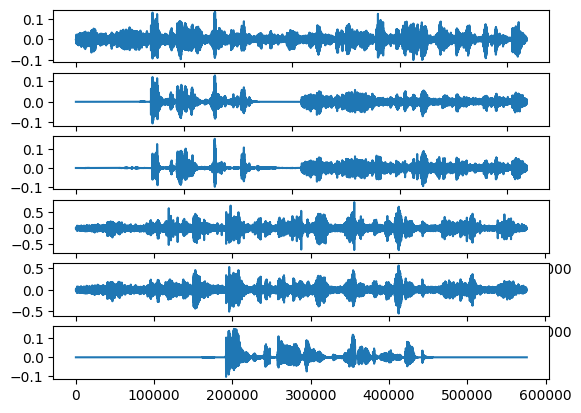

In [28]:
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=6)

ax0.plot(mixture_np)
ax1.plot(sources_np)
ax2.plot(enhanced_np)
ax3.plot(amplified_np)
ax4.plot(amplified_clean_np)
ax5.plot(ref.flatten())

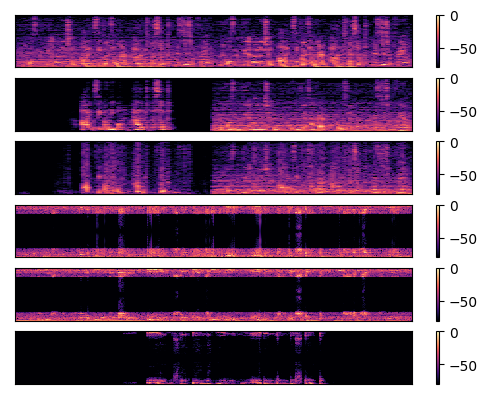

In [29]:
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=6, sharey=True)

def show_stft(y, _fig, _ax):
    D = librosa.stft(y, n_fft=4096)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, ax=_ax)
    _fig.colorbar(img, ax=_ax)

show_stft(mixture_np, fig, ax0)
show_stft(sources_np, fig, ax1)
show_stft(enhanced_np, fig, ax2)
show_stft(amplified_np, fig, ax3)
show_stft(amplified_clean_np, fig, ax4)
show_stft(ref.flatten(), fig, ax5)

In [30]:
ipd.Audio(mixture_np, rate=args.dset.sample_rate)

In [31]:
ipd.Audio(sources_np, rate=args.dset.sample_rate)

In [32]:
ipd.Audio(enhanced_np, rate=args.dset.sample_rate)

In [33]:
ipd.Audio(amplified_np, rate=config_clarity_challenge.nalr.fs)

In [34]:
ipd.Audio(amplified_clean_np, rate=config_clarity_challenge.nalr.fs)

In [35]:
ipd.Audio(ref.flatten(), rate=config_clarity_challenge.nalr.fs)